# An analysis on 2019 Hong Kong District Council Elections

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Introduction
<p>The 2019 Hong Kong District Council Elections were held on the 24th of November, roughly half a year after the start of the still on going movement calling for Hong Kong democratic reform and full investigation on police brutality and crime during the whole movement. The elections were generally regarded as the political statement of the Hong Kong general public made to the world and the Chinese government after half a year, while the appointed councilors do not have any legislative or executive power in the whole Hong Kong political environment, but merely local administrative power.</p>
<p>This is a graphical and simple statistical analysis on the registered voters data and the election results statistics on the two major camps, namely Pro-democracy camp, and Pro-Beijing(China) camp, and some independence candidates. The analysis aims to unravel the public opinions in different districts in Hong Kong and the correlation of voting rate and the winning camp, which led to the landslide victory of the Pro-democracy camp in this election.</p>
<p>Disclaimer: This an objective analysis with no underlying political stance involved, and this piece of research is not aiding any side or any stake holders on purpose.</p>

### Analysis and Steps

<p>1. Define function 'age_range_selector' that help concatenate different age groups.</p>

In [2]:
def age_range_selector(low,high):
    col = []
    if (low-1)%5==0:
        base = low
    else:
        base = low + (6-((low-1)%5+1))
    if (base<16) | low in [17,18]:
        base=16
    if (high%5)==0:
        maxi=high
    else:
        maxi = high-(high%5)
    if (maxi>70) | high in [71,72,73,74]:
        maxi = 75
       
    if (base-1)>= maxi:
        print('Error: invalid input')
        
    while (base-1)<maxi:
        app = 'age'+str(base)+'_'+str(base+4)
        if app=='age16_20':
            app='age18_20'
        elif app=='age71_75':
            app='age71_'        
        col.append(app)
        base+=5
    return col


<p>2. Make a connection to the database 'election.db' and load the four tables, namely 'voters_stat', 'result', 'rate', and 'candidate'. Then view the top few rows of the tables to check if there is any problem.  </p>

In [3]:
conn = sqlite3.connect('election.db')
voters_stat = pd.read_sql_query('SELECT * from voters_stat',conn)
result = pd.read_sql_query('SELECT * from result',conn)
rate = pd.read_sql_query('SELECT * from vote_rate',conn)
candidate = pd.read_sql_query('SELECT * from candidate',conn)

In [4]:
voters_stat.head(3)

,stat_id,Code,Main_District,District,Area,Sex,age18_20,age21_25,age26_30,age31_35,age36_40,age41_45,age46_50,age51_55,age56_60,age61_65,age66_70,age71_
0,0,A01,HK Island,Central & Western,Chung Wan,M,36,104,108,122,165,188,201,214,224,219,194,386
1,1,A01,HK Island,Central & Western,Chung Wan,F,40,99,112,153,156,174,195,229,249,233,209,367
2,2,A02,HK Island,Central & Western,Mid Levels East,M,59,178,177,183,269,238,302,301,387,395,281,482


In [5]:
result.head(3)

,result_id,Code,Constituency,Candidate_No.,Candidate_Name,Votes_No.
0,0,A01,CHUNG WAN,1,HUI CHI FUNG,1618
1,1,A01,CHUNG WAN,2,WONG CHUNG WAI,1319
2,2,A02,MID LEVELS EAST,1,MOK KAM SUM,1993


In [6]:
rate.head(3)

,rate_id,district,electoral_size,aggregate_voter_turnout,turnout_rate
0,0,Central & Western,110483,77277,69.94
1,1,Wan Chai,74839,50846,67.94
2,2,Eastern,323725,233287,72.06


In [7]:
candidate.head(3)

,id,year,person_id,name_zh,name_en,election_type,cacode,constituency_id,age,camp,...,is_won,fb_id,ig_id,occupation_zh,occupation_en,political_affiliation_zh,political_affiliation_en,electoral_message_zh,electoral_message_en,email_or_website
0,4403,2019,1400,梁福元,LEUNG FUK YUEN,by-election,M10,1872,61.0,BEJ,...,1.0,n/a,None,商人,None,None,None,None,None,None
1,4404,2019,2443,文家駒,MAN KA KOY,by-election,M32,1894,34.0,IND,...,1.0,mankakoy,None,花式跳繩教練,None,獨立候選人,None,None,None,None
2,4405,2019,2453,文嘉豪,MAN KA HO DONALD,by-election,M32,1894,42.0,IND,...,0.0,n/a,None,註冊外國律師,None,None,None,None,None,None


<p>3. Gather all the information needed for our analysis from different tables utilising SQL JOINS and sub queries.</p>

In [8]:
p = pd.read_sql_query('''
SELECT p.Code, p.Main_District, p.District, p.Area,
    SUM(CASE WHEN p.camp='DEM' THEN [Votes_No.] ELSE 0 END) AS ProDemocracy,
    SUM(CASE WHEN p.camp='BEJ' THEN [Votes_No.] ELSE 0 END) AS ProBeijing,
    SUM(CASE WHEN p.camp='IND' THEN [Votes_No.] ELSE 0 END) AS Independence,
    SUM(p.[Votes_No.]) AS Total,
    k.[18-30],
    k.[31-40],
    k.[41-50],
    k.[51-60],
    k.[61-70],
    k.[71+],
    k.Total AS Total_voters
FROM (SELECT p.Code, k.Main_District, k.District, k.Area, p.Candidate_Name, p.camp, p.[Votes_No.]
    FROM (SELECT r.*, c.camp, c.person_id
        FROM result r
        JOIN candidate c ON r.Candidate_Name=c.name_en AND r.Code=c.cacode) p
    LEFT JOIN voters_stat k ON p.Code=k.Code
    GROUP BY person_id
    ORDER BY p.Code) p
JOIN (SELECT Code,
        SUM({0}) AS '18-30',
        SUM({1}) AS '31-40',
        SUM({2}) AS '41-50',
        SUM({3}) AS '51-60',
        SUM({4}) AS '61-70',
        SUM({5}) AS '71+',
        SUM({6}) AS Total
    FROM voters_stat
    GROUP BY Code
    ORDER BY Code) k ON p.Code=k.Code
GROUP BY p.Code
ORDER BY p.Code
'''.format('+'.join(age_range_selector(18,30)),
           '+'.join(age_range_selector(31,40)),
           '+'.join(age_range_selector(41,50)),
           '+'.join(age_range_selector(51,60)),
           '+'.join(age_range_selector(61,70)),
           '+'.join(age_range_selector(71,75)),
           '+'.join(age_range_selector(18,71))
          ),conn)
def pick_winner(x):
    win = ''
    out = ['ProDemocracy','ProBeijing','Independence']
    for i in range(len(['ProDemocracy','ProBeijing','Independence'])):
        if x[out[i]]==x[['ProDemocracy','ProBeijing','Independence']].max():
            win = out[i]
    return win
p['Winning_camp'] = p.apply(pick_winner,axis=1)
p.head(3)


,Code,Main_District,District,Area,ProDemocracy,ProBeijing,Independence,Total,18-30,31-40,41-50,51-60,61-70,71+,Total_voters,Winning_camp
0,A01,HK Island,Central & Western,Chung Wan,1618,1319,0,2937,499,596,758,916,855,753,4377,ProDemocracy
1,A02,HK Island,Central & Western,Mid Levels East,2672,1993,0,4665,808,910,1163,1497,1323,1007,6708,ProDemocracy
2,A03,HK Island,Central & Western,Castle Road,2669,2559,0,5228,954,975,1425,1765,1433,1008,7560,ProDemocracy


<p>We now have a dataset with all the 5 main districts, 18 dsitrict, district council constituencies, the number of votes each camp got respectively in each constituencies, and the age distribution of registered voters in each constituencies (Note that not all registered voters went to vote, so the voting rate in each constituencies vary).</p>

<p>4. Plot the total votes ratio of different camps in the 18 districts, compare with their respective age group voters ratio and voting rate, all sorted by the ratio of Pro Democracy camp in descending order.</p>

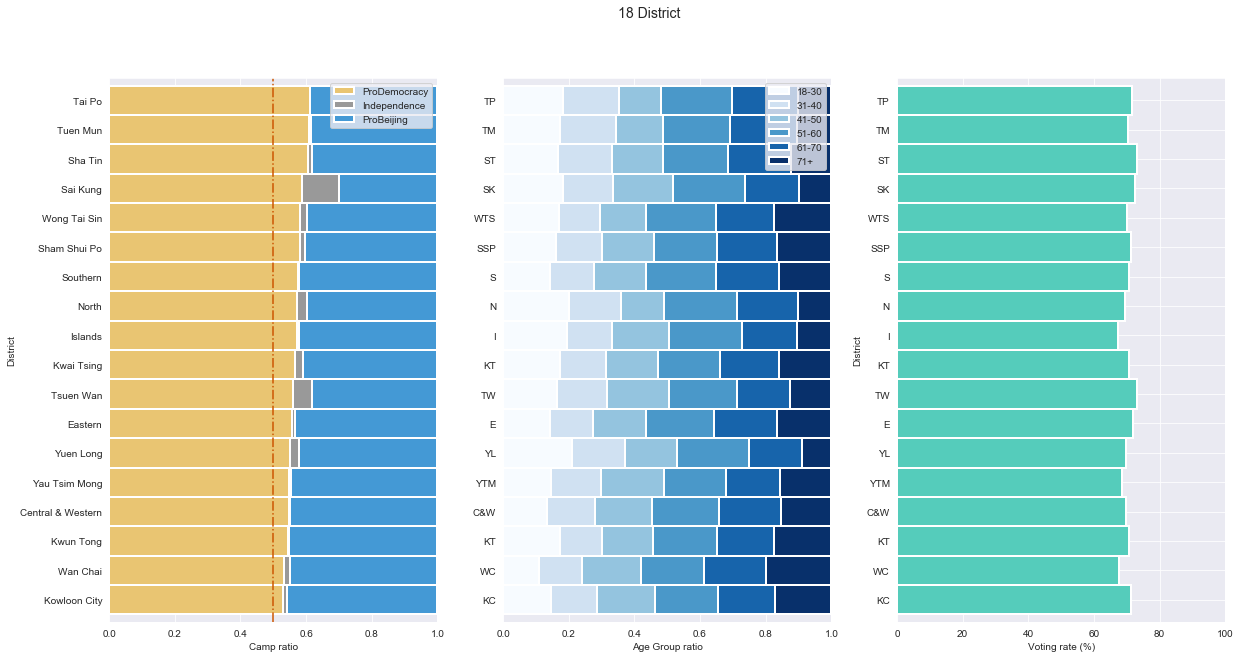

In [9]:
tem = p.groupby('District').sum()
tem['ProDemocracy'] = tem['ProDemocracy']/tem['Total']
tem['ProBeijing'] = tem['ProBeijing']/tem['Total']
tem['Independence'] = tem['Independence']/tem['Total']
tem['18-30'] = tem['18-30']/tem['Total_voters']
tem['31-40'] = tem['31-40']/tem['Total_voters']
tem['41-50'] = tem['41-50']/tem['Total_voters']
tem['51-60'] = tem['51-60']/tem['Total_voters']
tem['61-70'] = tem['61-70']/tem['Total_voters']
tem['71+'] = tem['71+']/tem['Total_voters']
tem['Total'] = tem['Total']*100/tem['Total_voters']
tem = tem.sort_values('ProDemocracy')
fig, ax = plt.subplots(1,3,figsize=(20,10))
fig.suptitle('18 District', fontsize=14)
tem[['ProDemocracy','Independence','ProBeijing']].plot(kind='barh', stacked=True,ax=ax[0],width=1,
                                                 color = ('#E9C572','#999999','#4499D5'),edgecolor='#FFFFFF',
                                                  linewidth=2)
ax[0].vlines(x=0.5,ymin=ax[0].get_ylim()[0],ymax=ax[0].get_ylim()[1],color='#CC5500',linewidth=1.5,linestyle='-.')
ax[0].set_yticklabels(labels = tem.index)
ax[0].set_xlim(0,1)
ax[0].set_xlabel('Camp ratio')

tem[['18-30','31-40','41-50','51-60','61-70','71+']].plot(kind='barh', stacked=True,ax=ax[1],width=1,
                                                 cmap = 'Blues',edgecolor='#FFFFFF',
                                                  linewidth=2)
# ('#AAD4FF','#77A0DD','#4477CC','#114599')
ax[1].set_yticklabels(labels = pd.Series(tem.index).apply(lambda st: ''.join([i[0] for i in st.split(' ')])))
ax[1].set_xlim(0,1)
ax[1].set_xlabel('Age Group ratio')
ax[1].set_ylabel('')

tem['Total'].plot(kind='barh',ax=ax[2],width=1,color='#55CCBB',edgecolor='#FFFFFF',linewidth=2)
ax[2].set_yticklabels(labels = pd.Series(tem.index).apply(lambda st: ''.join([i[0] for i in st.split(' ')])))
ax[2].set_xlim(0,100)
ax[2].set_xlabel('Voting rate (%)')

fig.tight_layout
fig.savefig(os.getcwd()+'/graph/18district.png')

<p>5. Plot a pie chart to see the seats taken by each camp.</p>

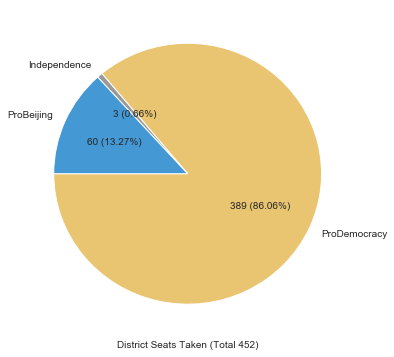

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
pie = p['Winning_camp'].value_counts()[['ProDemocracy',
                                  'Independence',
                                  'ProBeijing']]
pie.plot(kind='pie',
        colors = ('#E9C572','#999999','#4499D5'),
         ax=ax,
          startangle=180,
         autopct=(lambda pct: str(int(round(pct*452/100,0)))+' ({}%)'.format(round(pct,2))))
ax.set_xlabel('District Seats Taken (Total 452)')
ax.set_ylabel('')
fig.savefig(os.getcwd()+'/graph/distseatpie.png')

<p>6. Plot the total votes ratio of different camps in all the small districts within the 18 districts, compare with their respective age group voters ratio and voting rate, all sorted by the ratio of Pro Democracy camp in descending order.</p>

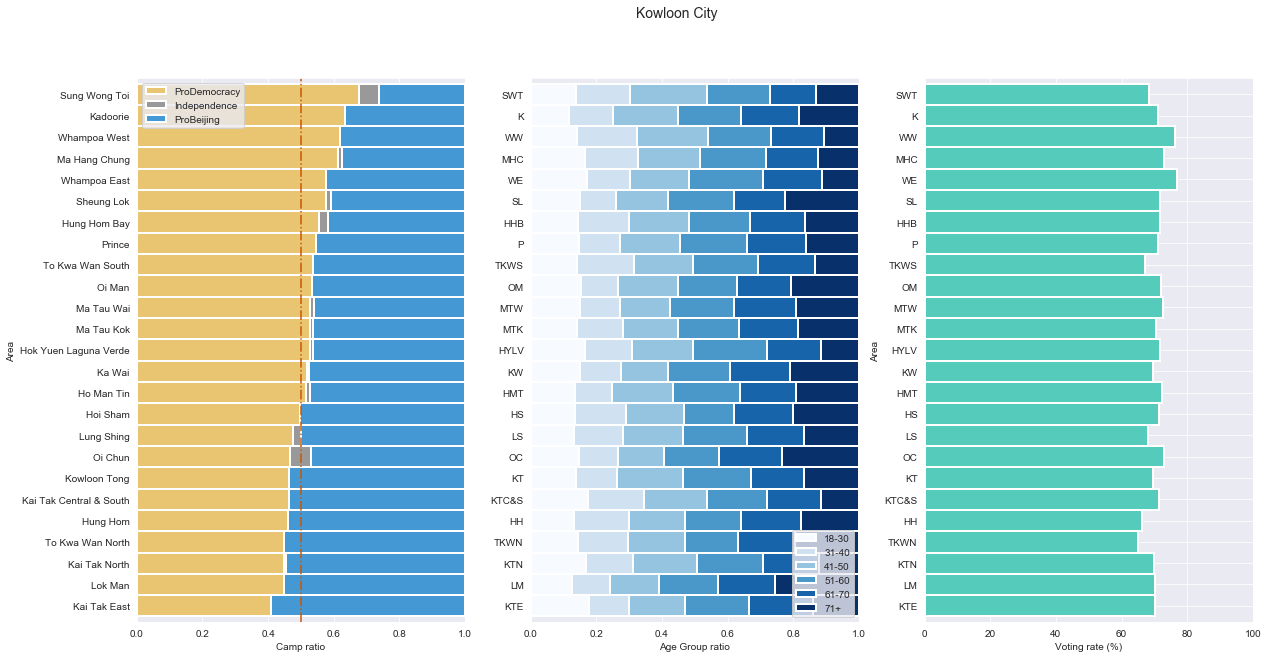

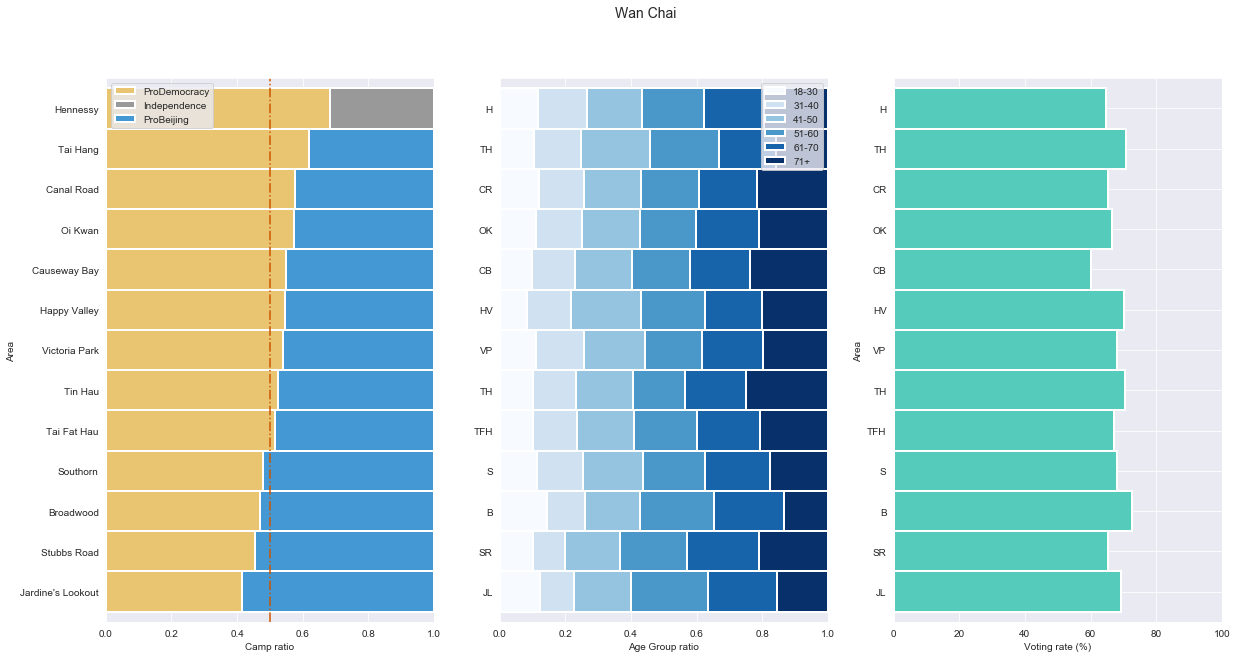

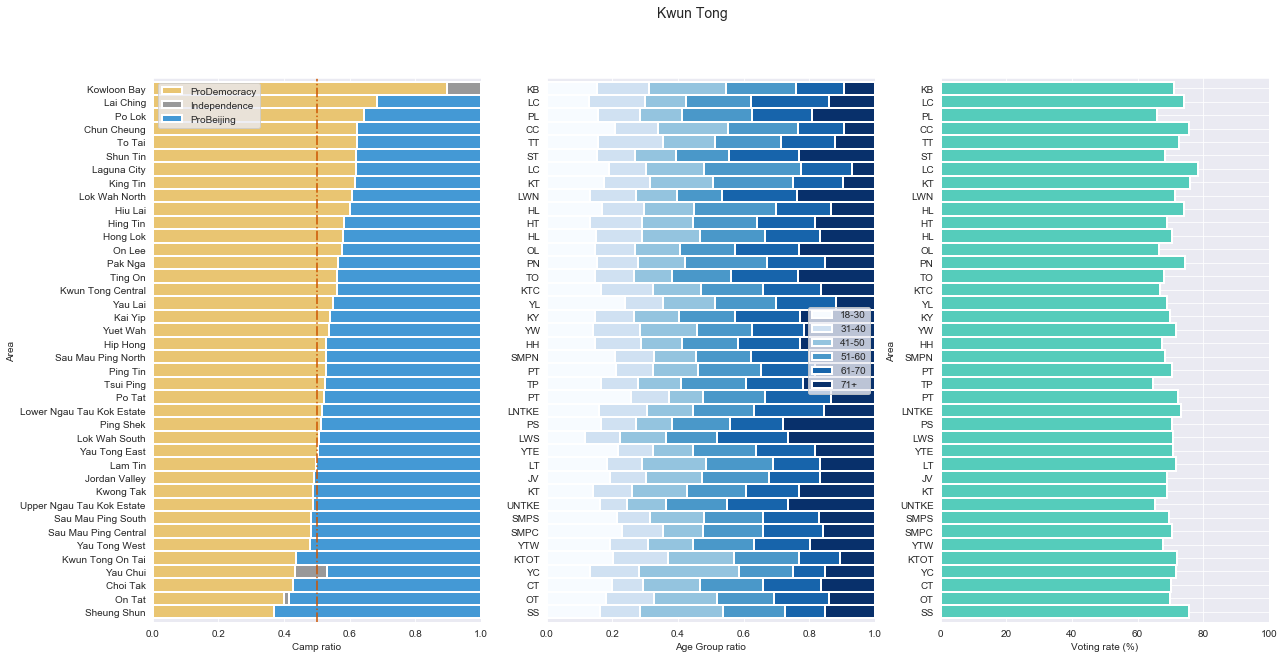

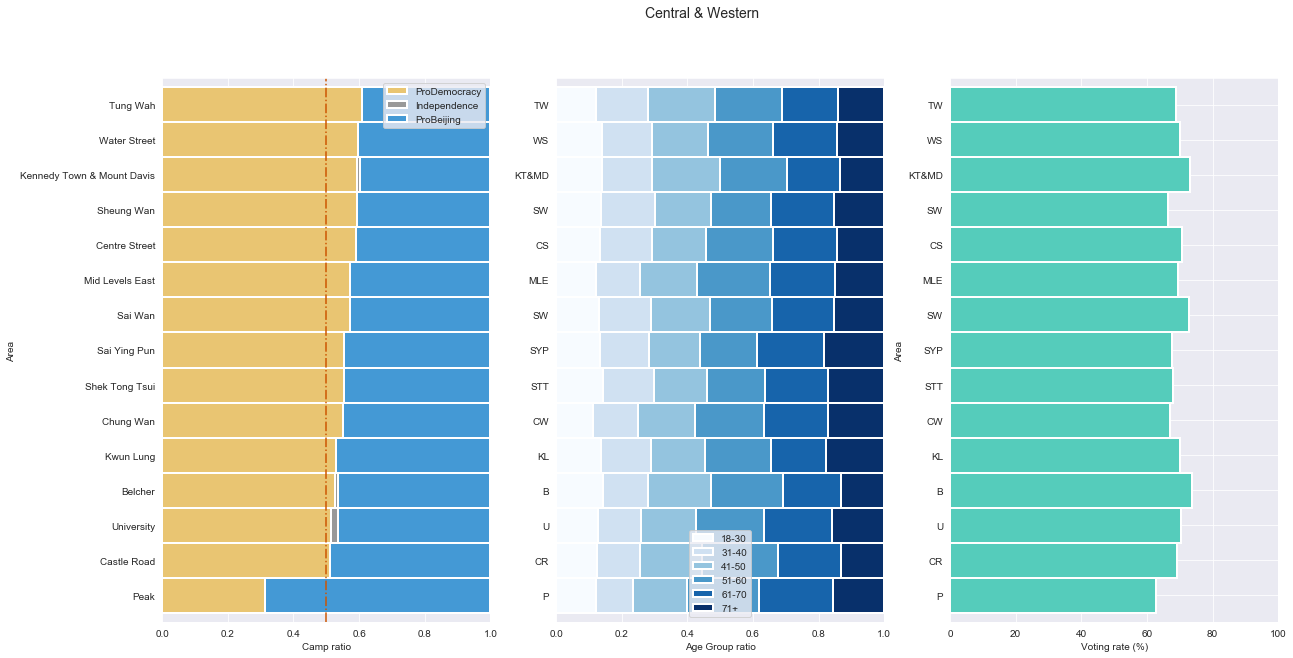

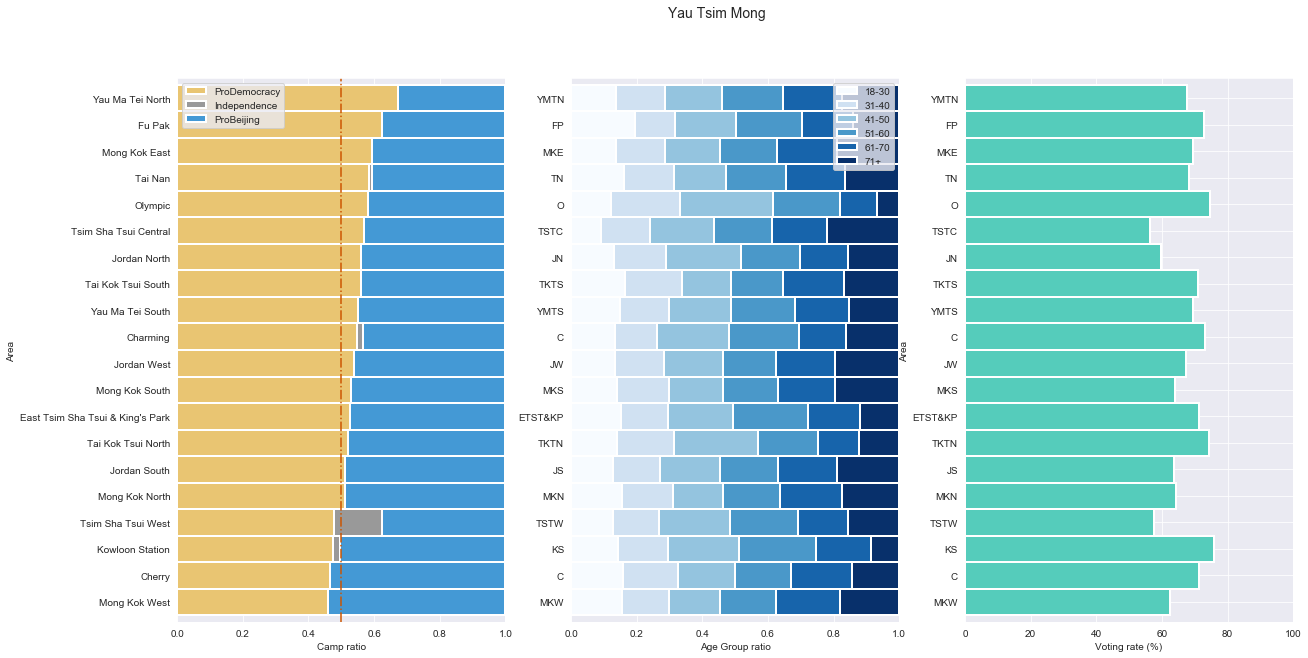

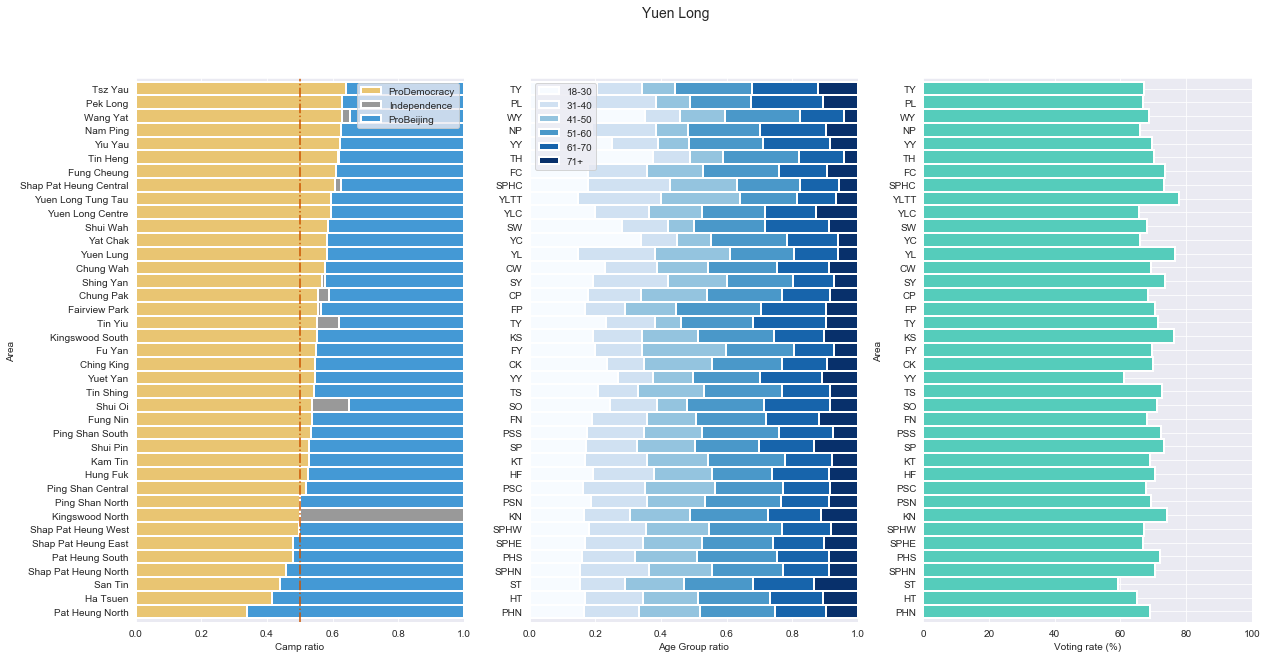

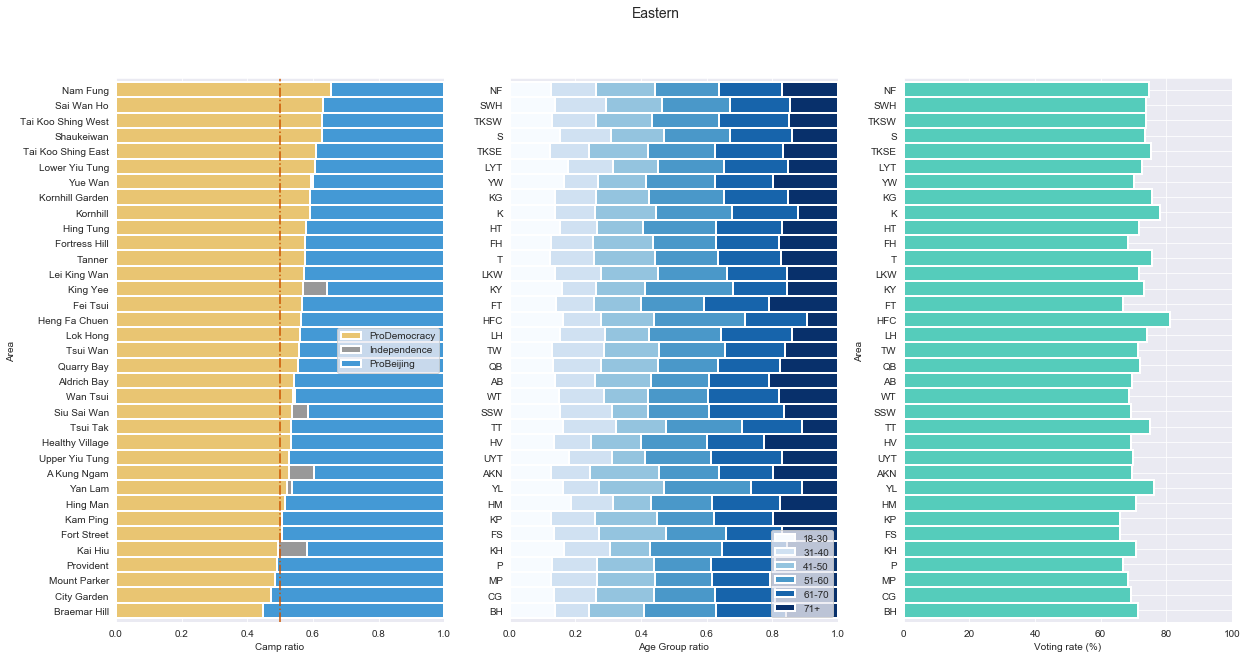

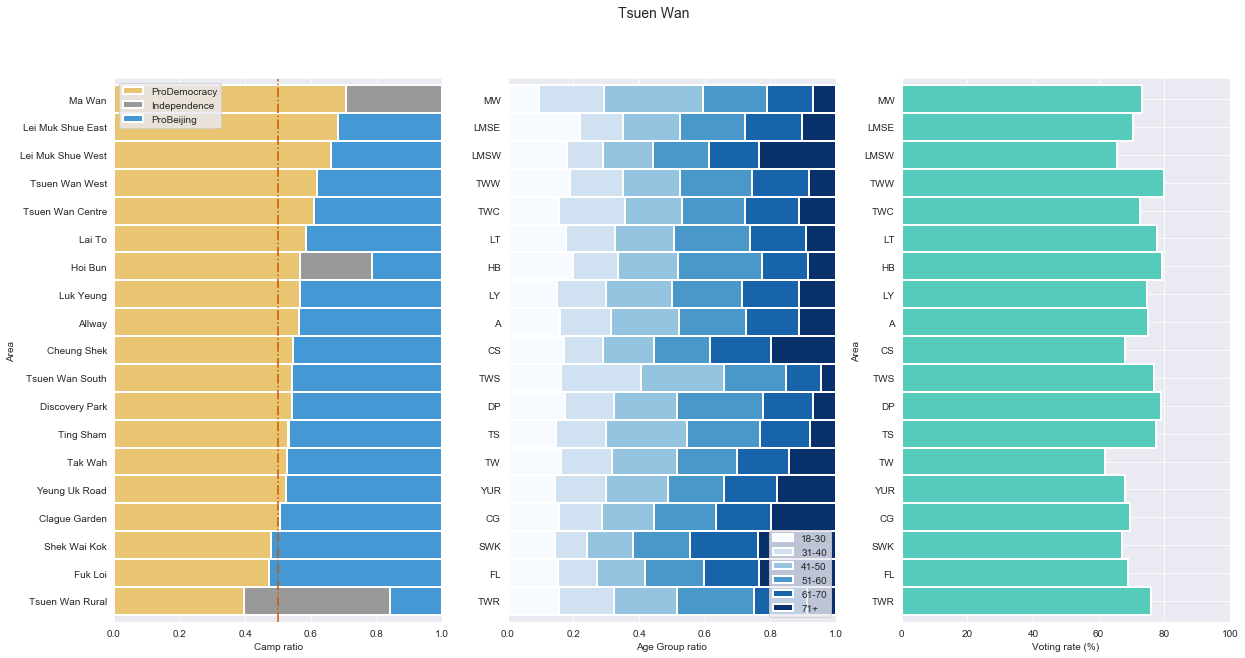

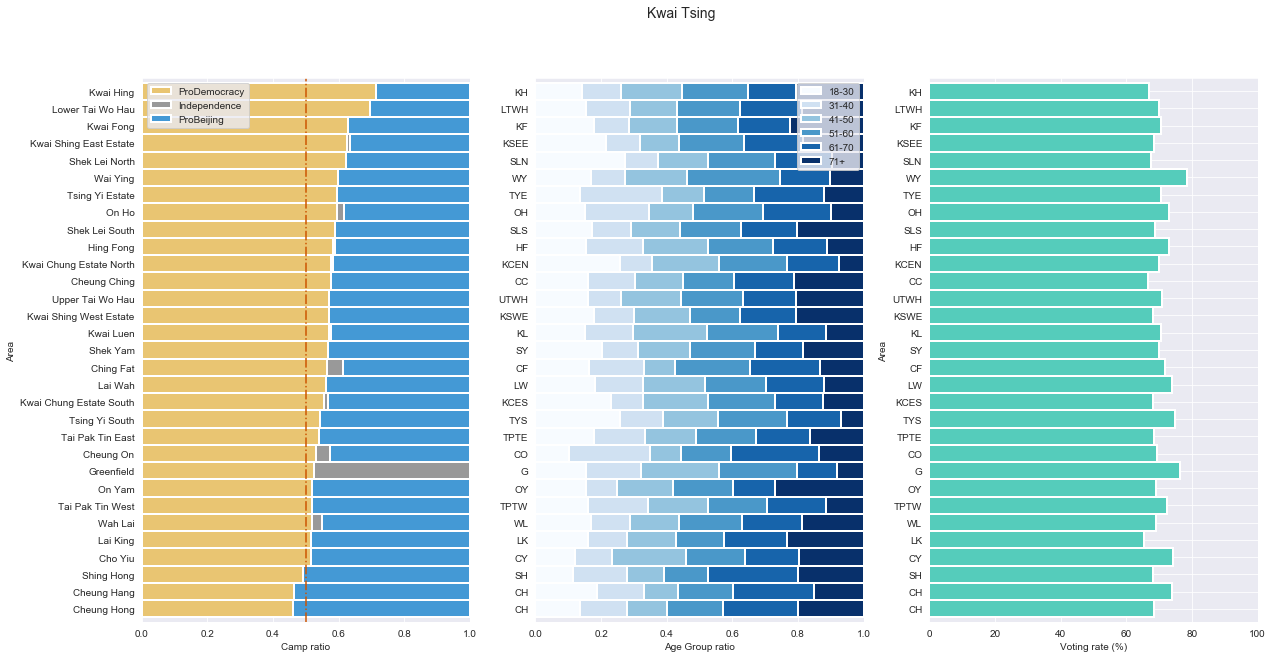

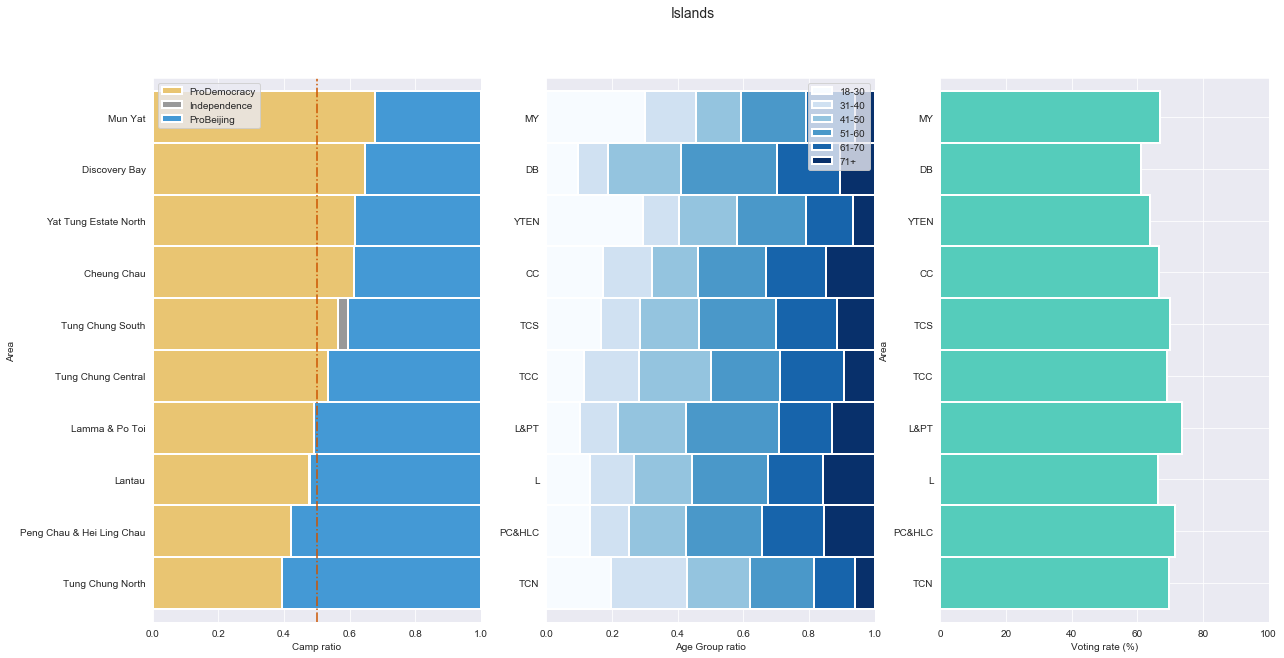

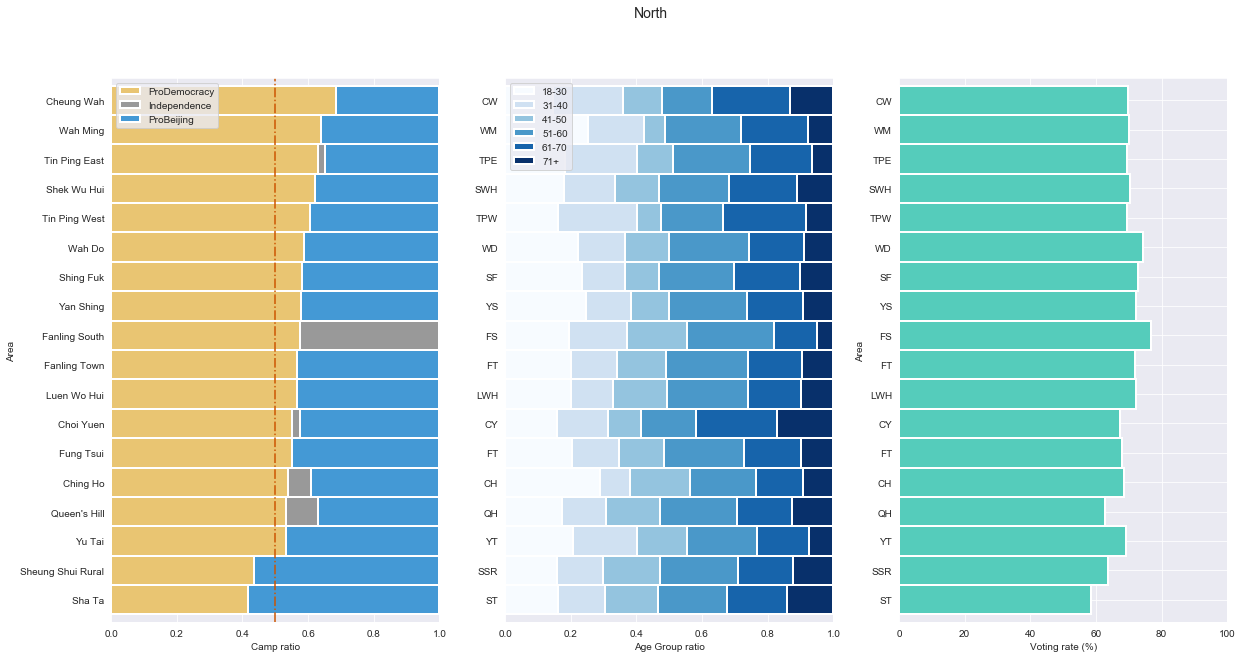

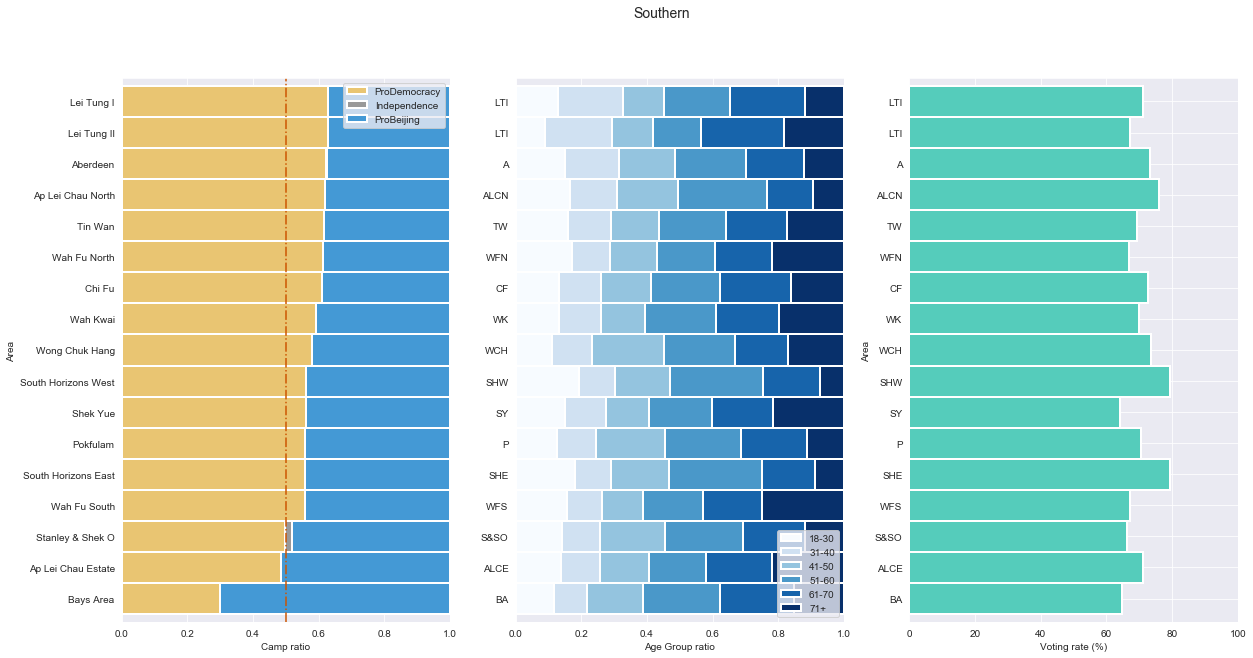

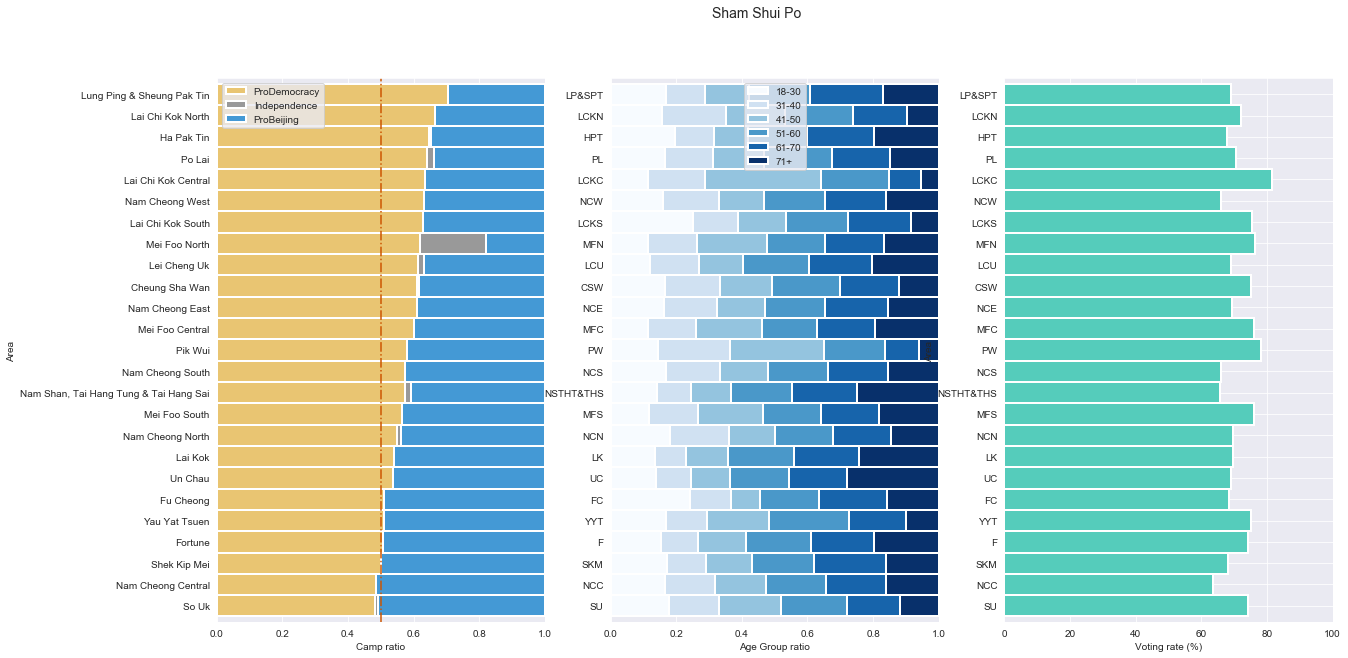

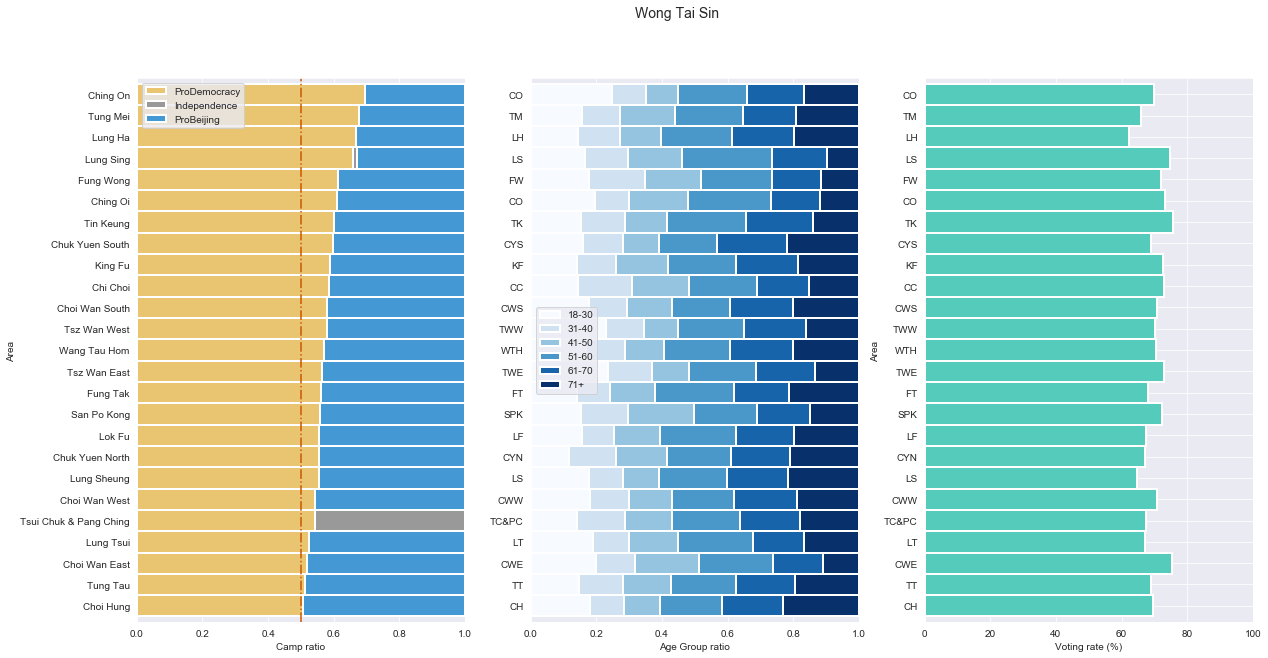

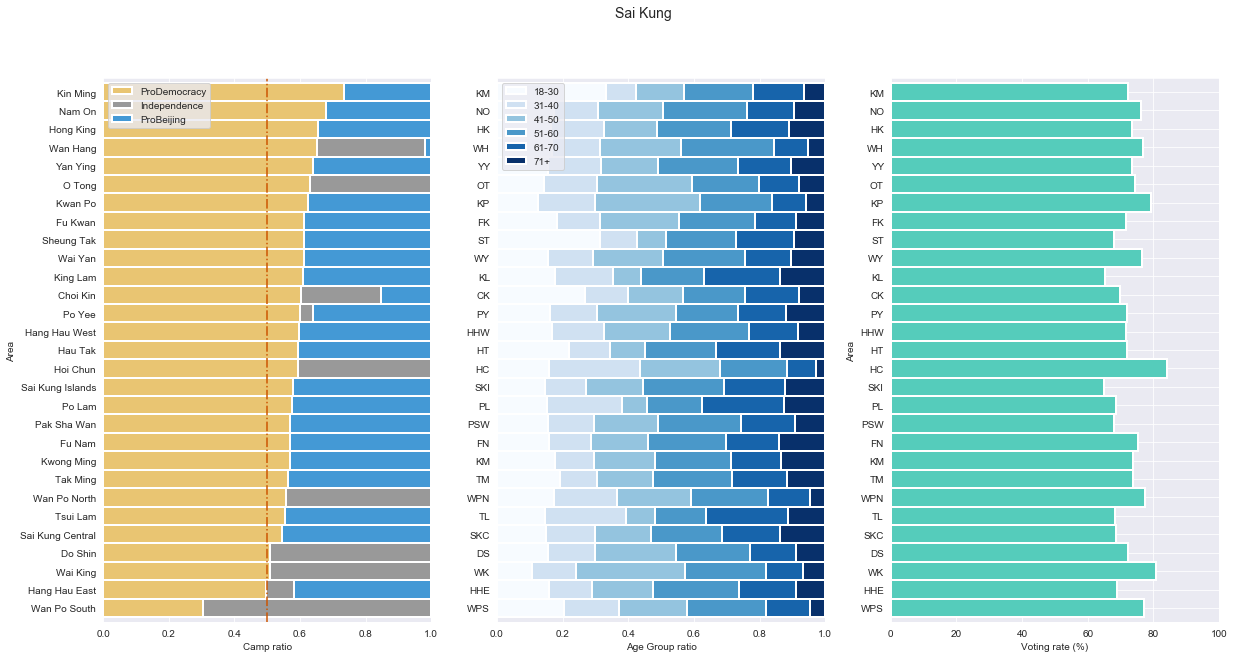

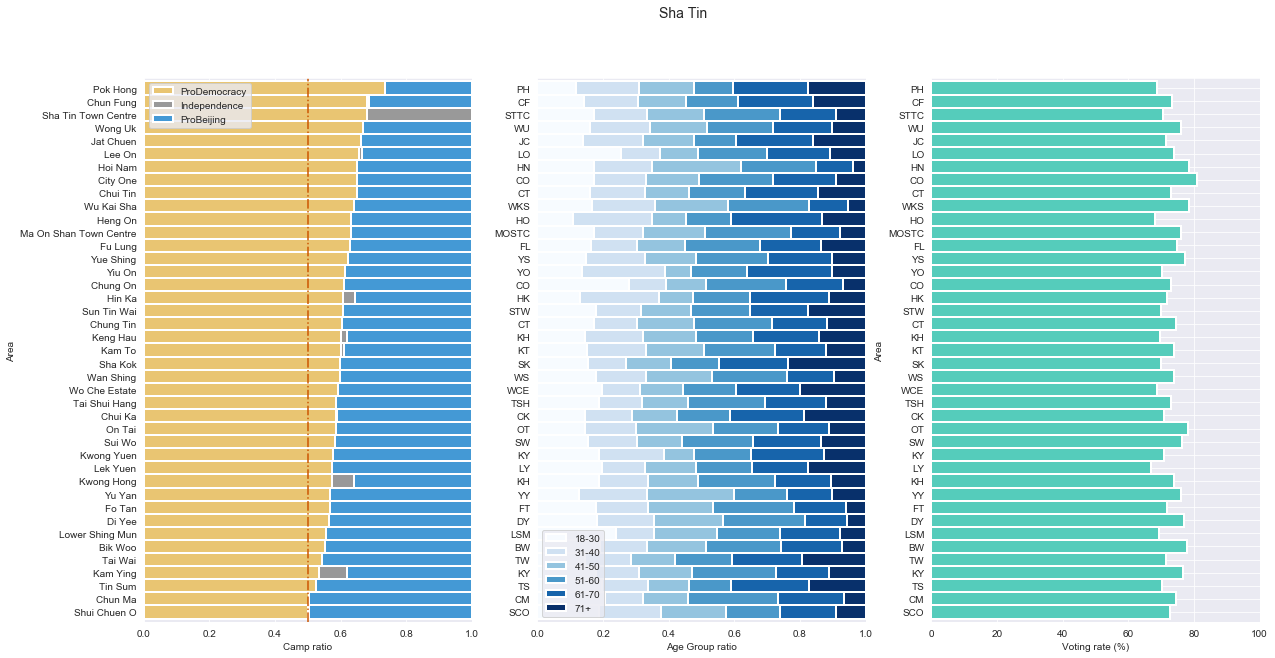

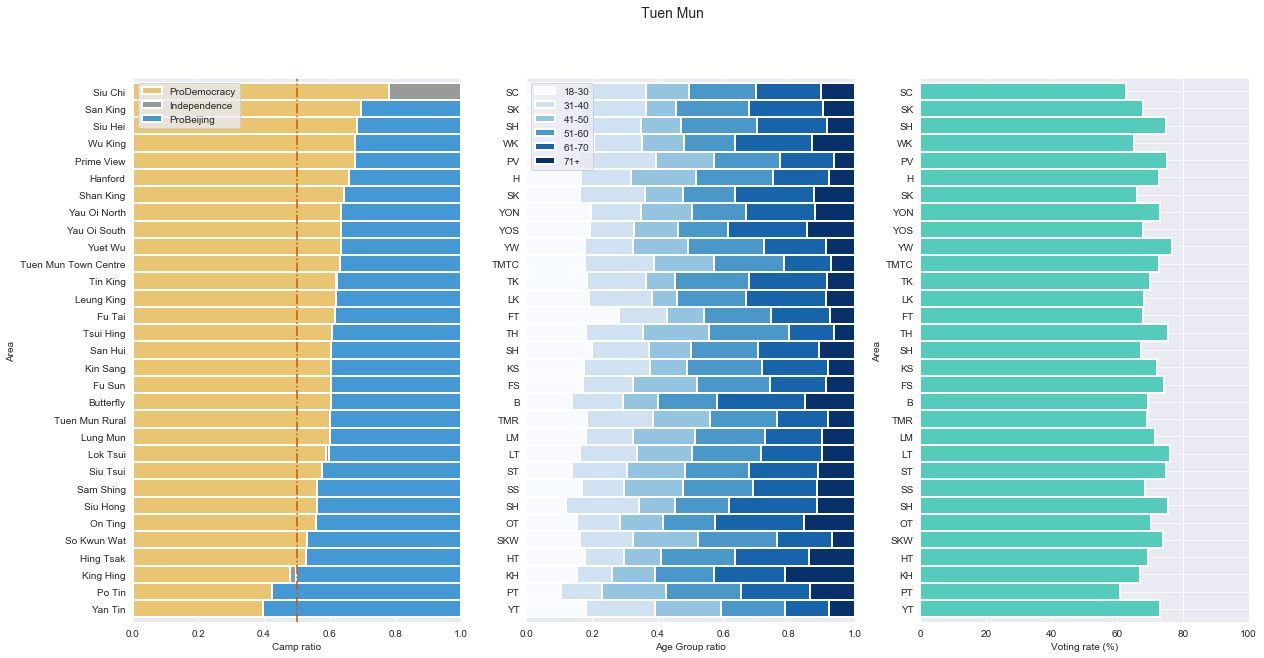

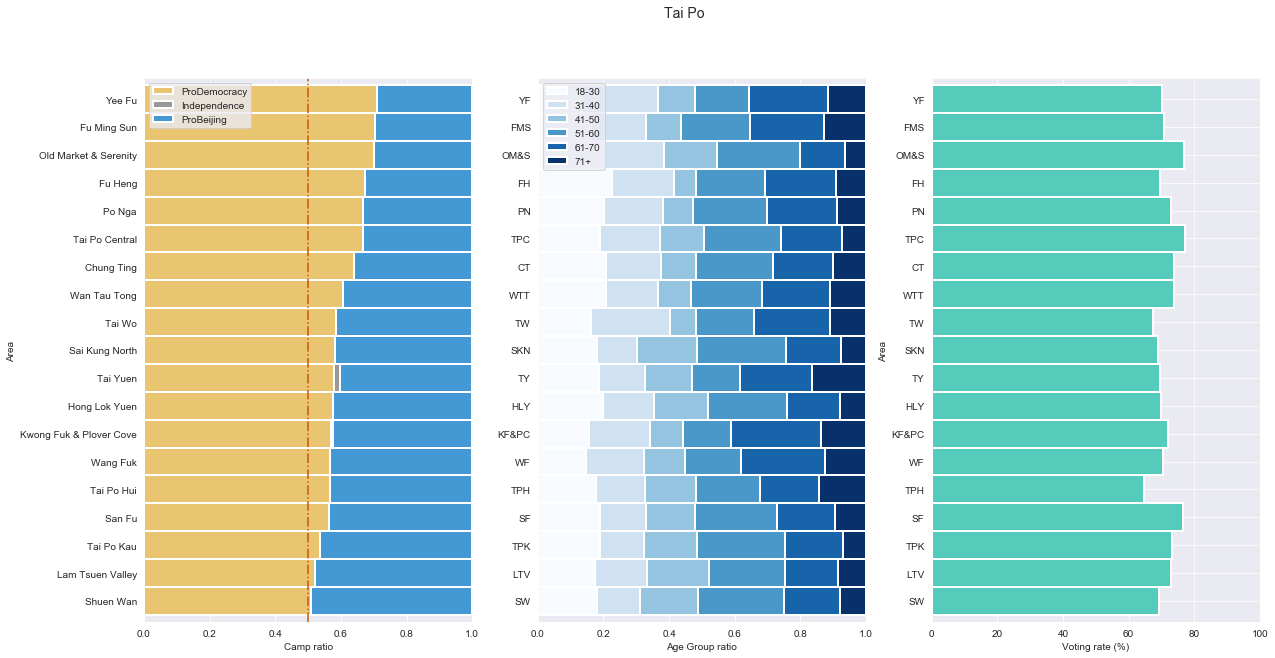

In [11]:
for dist in tem.index:
    temp = p[p['District']==dist].groupby('Area').sum()
    temp['ProDemocracy'] = temp['ProDemocracy']/temp['Total']
    temp['ProBeijing'] = temp['ProBeijing']/temp['Total']
    temp['Independence'] = temp['Independence']/temp['Total']
    temp['18-30'] = temp['18-30']/temp['Total_voters']
    temp['31-40'] = temp['31-40']/temp['Total_voters']
    temp['41-50'] = temp['41-50']/temp['Total_voters']
    temp['51-60'] = temp['51-60']/temp['Total_voters']
    temp['61-70'] = temp['61-70']/temp['Total_voters']
    temp['71+'] = temp['71+']/temp['Total_voters']
    temp['Total'] = temp['Total']*100/temp['Total_voters']
    temp = temp.sort_values('ProDemocracy')
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    fig.suptitle(dist, fontsize=14)
    temp[['ProDemocracy','Independence','ProBeijing']].plot(kind='barh', stacked=True,ax=ax[0],width=1,
                                                     color = ('#E9C572','#999999','#4499D5'),edgecolor='#FFFFFF',
                                                      linewidth=2)
    ax[0].vlines(x=0.5,ymin=ax[0].get_ylim()[0],ymax=ax[0].get_ylim()[1],color='#CC5500',linewidth=1.5,linestyle='-.')
    ax[0].set_yticklabels(labels = temp.index)
    ax[0].set_xlim(0,1)
    ax[0].set_xlabel('Camp ratio')

    temp[['18-30','31-40','41-50','51-60','61-70','71+']].plot(kind='barh', stacked=True,ax=ax[1],width=1,
                                                     cmap = 'Blues',edgecolor='#FFFFFF',
                                                      linewidth=2)
    # ('#AAD4FF','#77A0DD','#4477CC','#114599')
    ax[1].set_yticklabels(labels = pd.Series(temp.index).apply(lambda st: ''.join([i[0] for i in st.split(' ')])))
    ax[1].set_xlim(0,1)
    ax[1].set_xlabel('Age Group ratio')
    ax[1].set_ylabel('')
    
    temp['Total'].plot(kind='barh',ax=ax[2],width=1,color='#55CCBB',edgecolor='#FFFFFF',linewidth=2)
    ax[2].set_yticklabels(labels = pd.Series(temp.index).apply(lambda st: ''.join([i[0] for i in st.split(' ')])))
    ax[2].set_xlim(0,100)
    ax[2].set_xlabel('Voting rate (%)')
    fig.tight_layout

    fig.tight_layout
    fig.savefig(os.getcwd()+'/graph/{}.png'.format(dist))


<p>7. Trying to estimate the underlying proportion of pro democracy voters in Hong Kong by performing multilinear regression with 0 intercept. As the exact number of voters in each age group in each district is unknown, a constant voting rate among the age groups in each district assumption is made here (which is very controversial and may affect the result significantly, thus this estimation is just for fun). </p>
<p>Below is the top few rows of the table with the estimated voters number in each district under the assumption, and the actual number of votes of the Pro-democracy camp got in the respective districts, which is our dependent variable in the regression.</p>

In [12]:
import statsmodels.api as sm

In [13]:
reg = p[['Code','18-30', '31-40', '41-50', '51-60', '61-70',
       '71+', 'Total', 'Total_voters','ProDemocracy']]
reg['rate'] = reg['Total']/reg['Total_voters']
for col in [ '18-30', '31-40', '41-50', '51-60', '61-70','71+']:
    reg[col] = reg[col]*reg['rate']
reg.index = reg.Code
reg.drop(['Code','Total', 'Total_voters','rate'],axis=1,inplace=True)


In [14]:
reg.head(3)

,18-30,31-40,41-50,51-60,61-70,71+,ProDemocracy
Code,,,,,,,
A01,334.832762,399.920493,508.623715,614.642906,573.711446,505.268677,1618
A02,561.914132,632.848837,808.794723,1041.071109,920.064848,700.306351,2672
A03,659.723810,674.246032,985.436508,1220.558201,990.968783,697.066667,2669


In [15]:
X = reg.iloc[:,:-1]
y = reg.iloc[:,-1]
linear_model = sm.OLS(y,X)
results = linear_model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ProDemocracy   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     6813.
Date:                Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:11:09   Log-Likelihood:                -3352.7
No. Observations:                 452   AIC:                             6717.
Df Residuals:                     446   BIC:                             6742.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
18-30          0.6327      0.067      9.506      0.0

<p>The 'coef' column in th above summary are the caculated pro democracy voters proportions of each age group in Hong Kong. As mentioned before, the assumption made and the methodology used to estimate this set of theoretical numbers are extremely controversal. Therefore, making any conclusion regarding this set of numbers are not recommended.</p>

<p>8. Finding the relationship between pro democracy ballots portion and the voting rate with linear regression.</p>

In [16]:
reg = p[['Code','Total', 'Total_voters','ProDemocracy']]
reg['ProDemocracy'] = reg['ProDemocracy']/reg['Total']
reg['rate'] = reg['Total']/reg['Total_voters']
reg.index = reg.Code
reg.drop(['Code','Total', 'Total_voters'],axis=1,inplace=True)

In [17]:
reg.head(3)

,ProDemocracy,rate
Code,,
A01,0.550902,0.671008
A02,0.572776,0.695438
A03,0.510520,0.691534


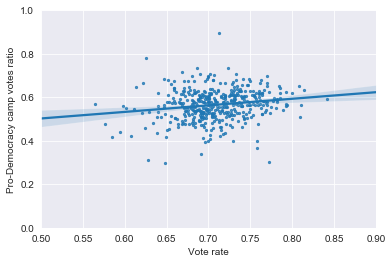

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(0.5,0.9)
ax.set_ylim(0,1)
sns.regplot(reg['rate'],reg['ProDemocracy'],ax=ax,scatter_kws={'s':5},ci=95)
ax.set_ylabel('Pro-Democracy camp votes ratio')
ax.set_xlabel('Vote rate')
fig.savefig(os.getcwd()+'/graph/voteVSwin.png')

In [19]:
X = sm.add_constant(reg['rate'])
y = reg['ProDemocracy']
linear_model = sm.OLS(y,X)
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ProDemocracy   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     14.17
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           0.000189
Time:                        00:11:10   Log-Likelihood:                 567.13
No. Observations:                 452   AIC:                            -1130.
Df Residuals:                     450   BIC:                            -1122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3519      0.057      6.187      0.0

<p>As we can see, although the slope of the regression line is not very steep and the distribution of the data is loose (low R-squared), the margin of the 95% confidence interval of the slope is still positive. The Durbin Watson statistic is also quite close to 2, indicating there is no anomaly among the residue. Thus, we can conclude that the voting rate do have positive relationship to the number of pro democracy vote, meaning high voting rate favours the pro democracy camp.</p>

<p>** Additional information: Distribution of registered voters' age group.</p>

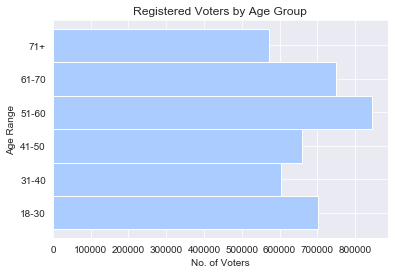

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
p[['18-30', '31-40', '41-50','51-60', '61-70', '71+']].sum().plot(kind='barh',width = 1,color='#AACCFF',ax=ax)
ax.set_title('Registered Voters by Age Group')
ax.set_xlabel('No. of Voters')
ax.set_ylabel('Age Range')
fig.savefig(os.getcwd()+'/graph/AgePopulation.png')

In [21]:
conn.close()